<h1>Getting started with TensorFlow</h1>
<p>The following notebook assumes limited to no knowledge of TensorFlow, but it will require basic Python literacy and for the TensorFlow, Numpy, and Matplotlib modules to be installed (They should be unless you maliciously uninstalled them.)</p>

In [1]:
import tensorflow as tf
import numpy as np

/home/student/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


<h2>Lesson Goals:</h2>
<ol>
    <li>Understanding Machine Learning Models as Function Approximators.</li>
    <li>Defining ML Models in TensorFlow</li>
</ol>
<a name="FunctionApproximator"></a>
<h3>Understanding Machine Learning Models as Function Approximators</h3>
<p>In general, most ML models are made with a very simple purpose: to produce 'intelligent' output for a given problem. This is an over simplified way of thinking of things, but it reveals some of our key goals: we want to make a model which produces output we like based on a set of input(s). In this sense, we can imagine our ML model as a universal function approximator: something which mimics the output we would like given a set of examples. For this lesson, we will start by loading a set of data and making a model which can accurately predict values for our unknown function.</p>
<h3>Loading the data</h3>
<p>We begin by using Python's pickle module to load the binary data file containing our unknown function's input and output examples.</p>

In [52]:
import pickle
file_name = 'data.p'
data = None
with open(file_name, 'rb') as out_file:
    data = pickle.load(out_file)
if data is not None:
    print('Loaded data from {}.\nData:{}'.format(file_name, data))

Loaded data from data.p.
Data:{'inputs': array([ 27.25,  37.25,   8.75,  43.75,  32.75,  16.5 ,  49.75,   7.5 ,
        45.25,   4.75,  41.25,  39.  ,  21.25,  48.5 ,   2.25,  33.25,
        27.25,  12.  ,  32.25,  42.75,  25.75,  17.75,  12.25,  49.75,
        33.  ,  27.75,   4.5 ,   6.25,   1.  ,  16.  ,  38.75,   8.75,
        38.75,  15.75,  36.25,   2.25,  27.  ,   9.75,  36.25,  38.  ,
        45.25,  42.75,  47.75,   1.  ,  12.75,  21.25,  10.25,  27.5 ,
        21.5 ,  38.25,  38.75,  28.25,  37.5 ,  47.5 ,  50.  ,  42.25,
        11.  ,   6.25,  39.75,   9.75,  48.25,  35.5 ,   0.  ,  32.5 ,
         3.75,  28.75,  13.5 ,  41.75,  34.75,  50.  ,  48.75,  43.75,
        12.  ,  12.  ,   0.25,  37.  ,  25.5 ,  35.75,  48.75,  32.75,
        31.5 ,   1.25,  38.  ,  18.  ,   1.5 ,  27.75,  10.5 ,  30.25,
        16.  ,   9.75,  16.5 ,  50.  ,   1.25,  10.75,  12.5 ,  29.25,
        24.5 ,  44.5 ,  39.  ,  38.75]), 'outputs': array([-14.16095605,  33.55603166,  -6.83239973,  42.57

<p>The previous code should print out the data for our inputs and outputs, but it would probably be helpful to display the data on a graph so we can get a better idea of what kind of function we are trying to model. The following code plots our data as a series of red points.</p>

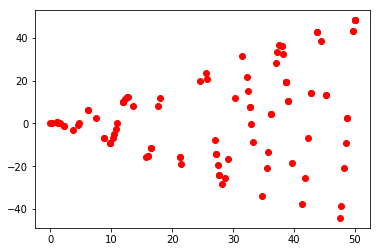

In [53]:
import matplotlib.pyplot as plt
plt.plot(data['inputs'], data['outputs'], 'ro')
plt.show()

<p>Since we have a set of input/output examples showing the expected output of our model, we could classify this ML problem as a <i>supervised learning</i> problem. In this case, we know that the output of our model should closely match that of the graph above.</p>

<a name="Reset"></a>
<h2>Resetting the TensorFlow graph.</h2>
<p>The following code resets the TensorFlow graph. This is typically run before creating your networks to ensure that there are no duplicate tensors.</p>

In [2]:
tf.reset_default_graph()